In [60]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import glob
import os

from math import log

plt.style.use('ggplot') # Make the graphs a bit prettier

In [5]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/lp_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [6]:
frames['program_run']['worker_label'] = frames['program_run']['hosts'].map(str) + 'x' + frames['program_run']['workers_per_host'].map(str)

,timestamp,commit,binary,job_id,workers_per_host,edge_count,node_count,graph,runtime,hosts,total_workers,worker_label
09422589-7f73-4ac1-90d8-0dc203a441ef,2017-05-19 10:44:38 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837689,1,132018381,1000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,279.148186,1,1,1x1
0a60c712-ce5f-42bd-beb6-de7a35b14ff0,2017-05-19 10:44:38 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837708,27,1320354525,10000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,NaN,8,216,8x27
0ed2f639-a13c-4c1e-bff6-80805d8abdb5,2017-05-19 10:44:39 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837709,1,13203573605,100000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,6656.282128,8,8,8x1
1ad20cd7-6f30-40b9-8e7f-ade43283a5e6,2017-05-19 10:44:38 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837695,16,132018381,1000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,35.999904,2,32,2x16
235255e6-fa16-490c-8cb3-22f90b9f66de,2017-05-19 10:44:40 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837716,27,13203573605,100000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,995.498393,16,432,16x27
2f9e19ba-9933-4979-91cc-7a9176dde6bc,2017-05-19 10:44:40 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837713,1,13203573605,100000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,2618.313254,16,16,16x1
3410af33-3b03-4aef-8d49-6a05fe104ba4,2017-05-19 10:44:38 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837706,4,1320354525,10000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,137.884423,8,32,8x4
3536712e-dfbc-4e56-b805-b36586c7b8c6,2017-05-19 10:44:39 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837691,16,132018381,1000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,23.398281,1,16,1x16
3dd08b53-102a-4475-96d5-e462bc08a5c6,2017-05-19 10:44:39 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837712,27,13203573605,100000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,2712.852347,8,216,8x27
41d300ff-16fc-417e-b328-e905843ec5b5,2017-05-19 10:44:40 +0200,e1e8543f32bb2c93fd9bd88ee744773cdff5e0cc,/home/kit/iti/kp0036/code/prototypes/thrill_lo...,11837700,27,1320354525,10000000,/home/kit/iti/kp0036/graphs/mu-04/graph_50_100...,168.191331,2,54,2x27


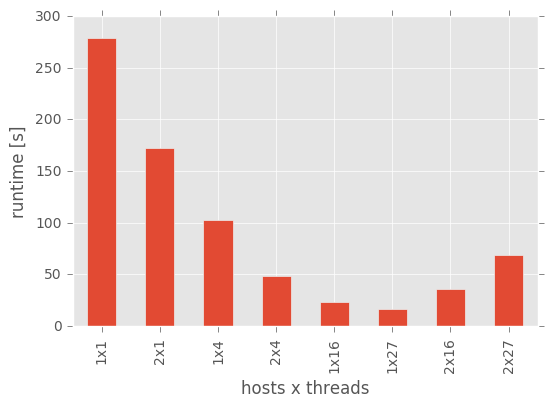

In [45]:
ax = frames['program_run'] \
    .loc[lambda x: x.node_count == 1000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime', legend=False)
    
ax.set_ylabel("runtime [s]")
ax.set_xlabel("hosts x threads")

In [1]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 1000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

NameError: name 'frames' is not defined

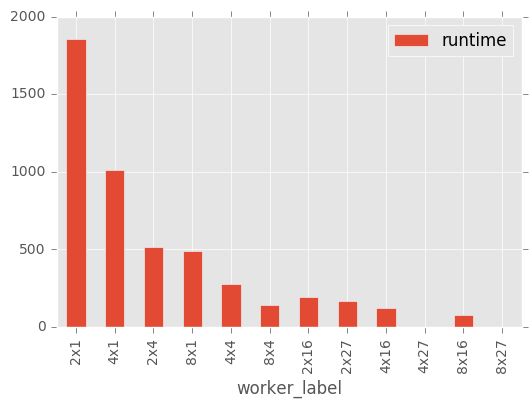

In [8]:
frames['program_run'] \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime')

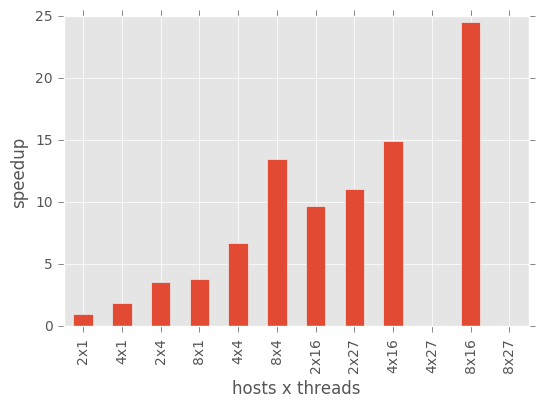

In [56]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 10000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

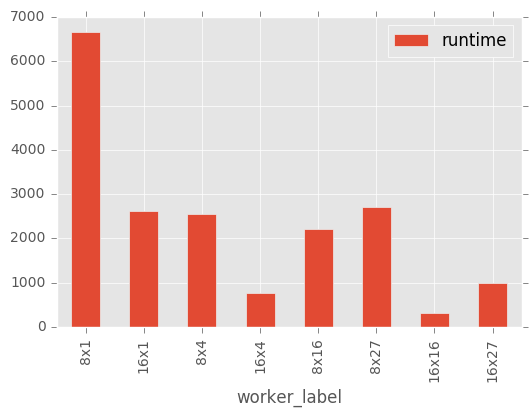

In [9]:
frames['program_run'] \
    .loc[lambda x: x.node_count == 100000000] \
    .sort_values(by='total_workers') \
    .plot.bar(x='worker_label', y='runtime')

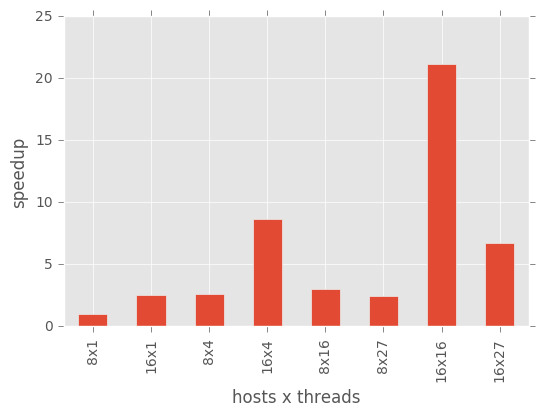

In [58]:
plot_data = frames['program_run'] \
    .loc[lambda x: x.node_count == 100000000] \
    .sort_values(by='total_workers')
    
plot_data['speedup'] = plot_data['runtime'].iloc[0] / plot_data['runtime']
    
ax = plot_data.plot.bar(x='worker_label', y='speedup', legend=False)
    
ax.set_ylabel("speedup")
ax.set_xlabel("hosts x threads")

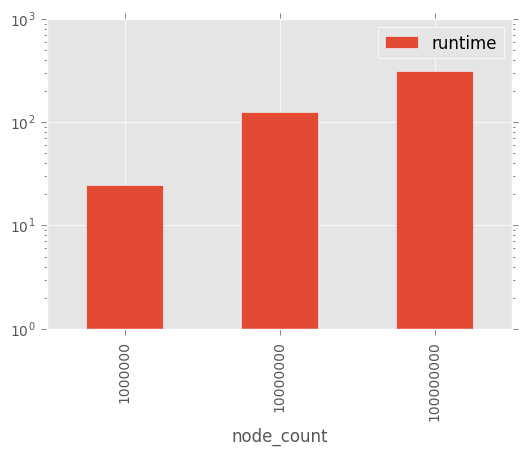

In [87]:
tmp = frames['program_run'] \
    .loc[lambda x: x.workers_per_host == 16] \
    .sort_values(by='node_count')
    
tmp = tmp[tmp.apply(lambda x: int(log(x['node_count'] / 1000000, 10)) == int(log(x['hosts'], 2)) / 2, axis=1)]

tmp.plot.bar(x='node_count', y='runtime', log=True)

In [49]:
frames['program_run'] \
    .sort_values(by='total_workers') \
    .groupby(['graph', 'worker_label'])['runtime'].mean().unstack('worker_label')

worker_label,16x1,16x16,16x27,16x4,1x1,1x16,1x27,1x4,2x1,2x16,2x27,2x4,4x1,4x16,4x27,4x4,8x1,8x16,8x27,8x4
graph,,,,,,,,,,,,,,,,,,,,
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_1000000-preprocessed-*.bin,NaN,NaN,NaN,NaN,279.148186,23.398281,16.332117,102.334275,172.047172,35.999904,68.558221,48.847658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_10000000-preprocessed-*.bin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1854.450354,191.847318,168.191331,516.737337,1012.113526,124.109318,NaN,276.466337,491.410053,75.633823,NaN,137.884423
/home/kit/iti/kp0036/graphs/mu-04/graph_50_10000_mu_0.4_100000000-preprocessed-*.bin,2618.313254,314.738288,995.498393,769.812139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6656.282128,2213.329716,2712.852347,2543.904597
